## Import Libraries

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn import mixture

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np

from scipy import linalg
from scipy.linalg import pinv
import scipy.stats 

import itertools

## Load Datasets

In [ ]:
hf_data = pd.read_csv('heart_failure.csv', low_memory=False)
s_data = pd.read_csv('healthcare_stroke.csv', low_memory=False)

In [ ]:
# used to determine the likelihood a patient will suffer from heart failure
hf_features = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'RestingECG', 'MaxHR', 'ExerciseAngina']

# used to determine the likelhood a patient will suffer from a stroke
s_features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

In [ ]:
X_hf = hf_data[hf_features]
Y_hf = hf_data.HeartDisease

# split dataset into training and test set
# 70% training, 30% test
X_hf_train, X_hf_test, Y_hf_train, Y_hf_test = train_test_split(X_hf, Y_hf, test_size=0.3, random_state=1)

# drop all infinite and nan
X_hf_train = X_hf_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
Y_hf_train = Y_hf_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

# convert strings to numerical labels
num = preprocessing.LabelEncoder()
X_hf_train = X_hf_train.apply(num.fit_transform)
X_hf_test = X_hf_test.apply(num.fit_transform)

In [ ]:
X_s = s_data[s_features]
Y_s = s_data.stroke

# split dataset into training and test set
# 70% training, 30% test
X_s_train, X_s_test, Y_s_train, Y_s_test = train_test_split(X_s, Y_s, test_size=0.3, random_state=1)

# drop all infinite and nan
X_s_train = X_s_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
Y_s_train = Y_s_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

# convert strings to numerical labels
X_s_train = X_s_train.apply(num.fit_transform)
X_s_test = X_s_test.apply(num.fit_transform)

# K-Means Analysis

## Heart Failure

### Results

In [75]:
kmeans = KMeans(n_clusters=7, random_state=3169)
kmeans.fit(X_hf_train)
print('K-Means Inertia: ', kmeans.inertia_)
silh_result = silhouette_score(X_hf_train, kmeans.labels_)
print('K-Means Silhouette score: ', silh_result)
AMI = adjusted_mutual_info_score(Y_hf_train, kmeans.labels_)
print('K-Means Adjusted Mutual Information (AMI) score: ', AMI)
print()
k_hf = kmeans.fit_transform(X_hf_train)
%store k_hf

K-Means Inertia:  420625.5701075719
K-Means Silhouette score:  0.27836932580418405
K-Means Adjusted Mutual Information (AMI) score:  0.06104324230675783

Stored 'k_hf' (ndarray)


### Inertia Analysis

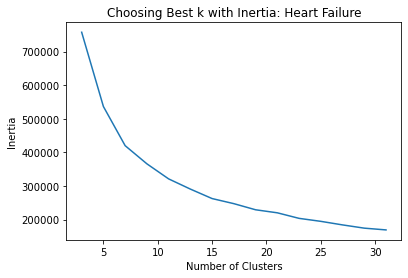

In [68]:
cluster_range = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
inertia_arr = []
for num_cluster in cluster_range:
    clusterer = KMeans(n_clusters=num_cluster, random_state=10)
    cluster_labels = clusterer.fit(X_hf_train)
    inertia_arr.append(clusterer.inertia_)
inertia_arr = np.array(inertia_arr)
plt.plot([3,5,7,9,11,13,15,17,19,21,23,25,27,29,31],inertia_arr)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Choosing Best k with Inertia: Heart Failure')
plt.savefig('inertia_hf.png')
plt.show()

### Silhouette Analysis

For n_clusters =  3 The average silhouette_score is : 0.36321856909542777
For n_clusters =  5 The average silhouette_score is : 0.3147138441295178
For n_clusters =  7 The average silhouette_score is : 0.28291871431728216
For n_clusters =  9 The average silhouette_score is : 0.26279488643027477
For n_clusters =  11 The average silhouette_score is : 0.2383506920510026
For n_clusters =  13 The average silhouette_score is : 0.237991172235641
For n_clusters =  15 The average silhouette_score is : 0.24069805656135856


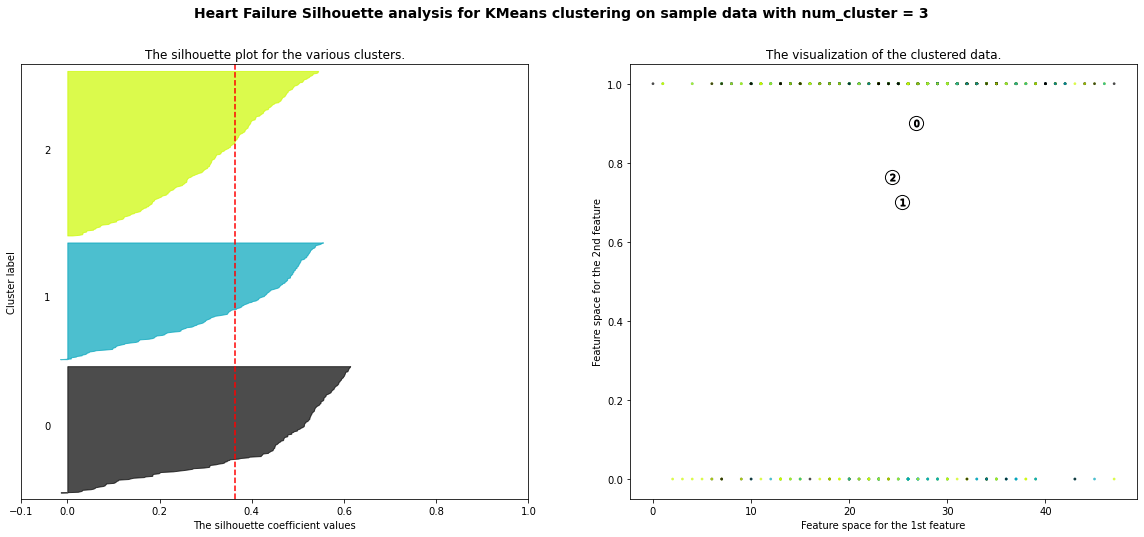

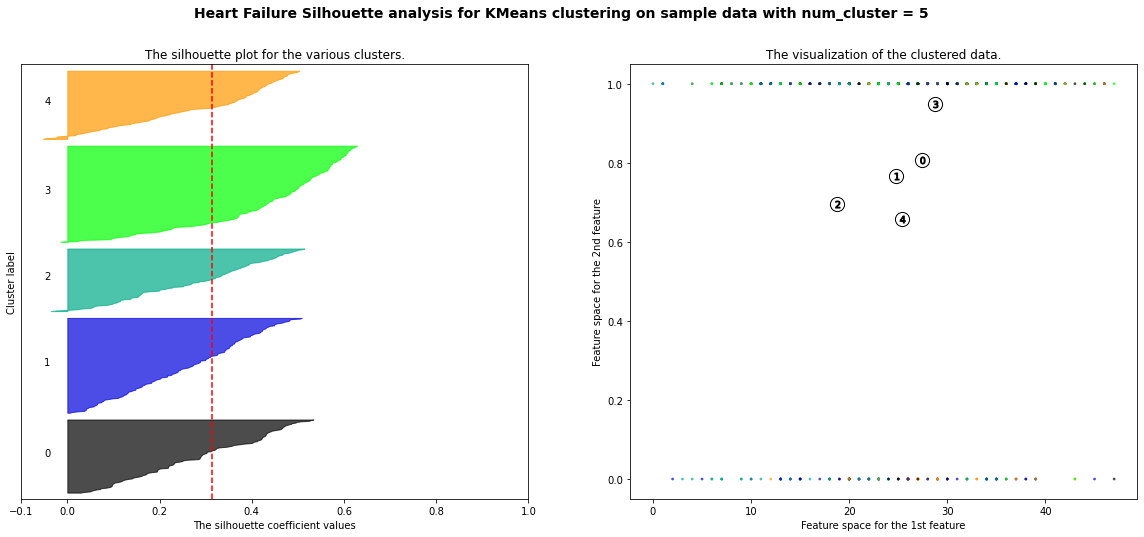

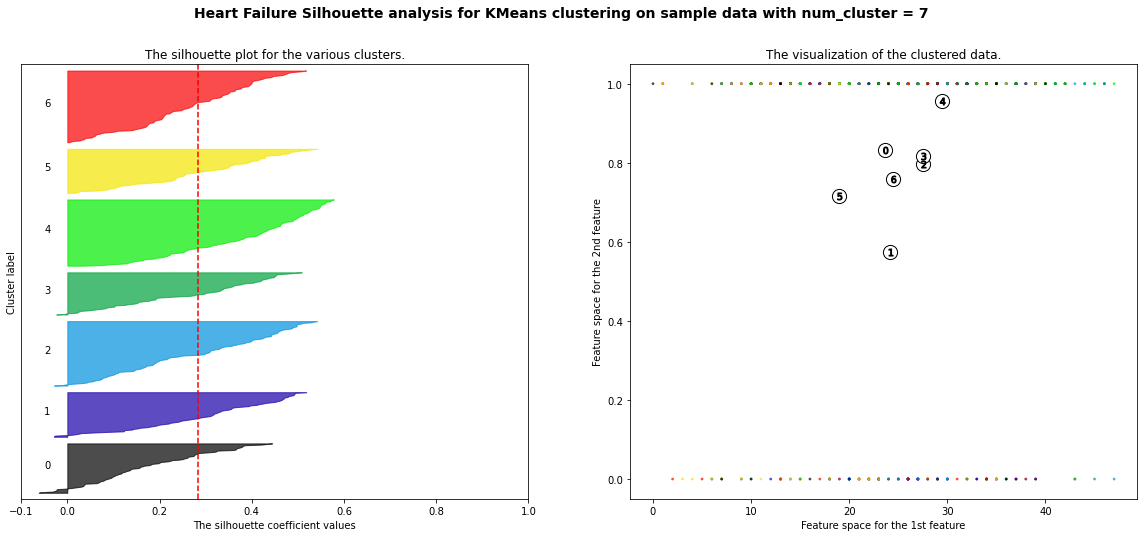

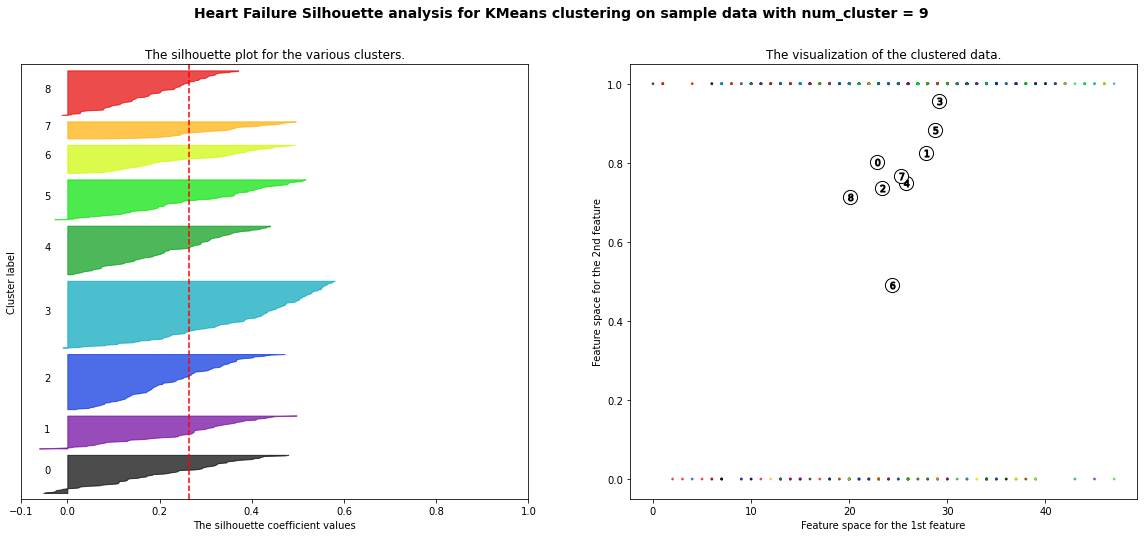

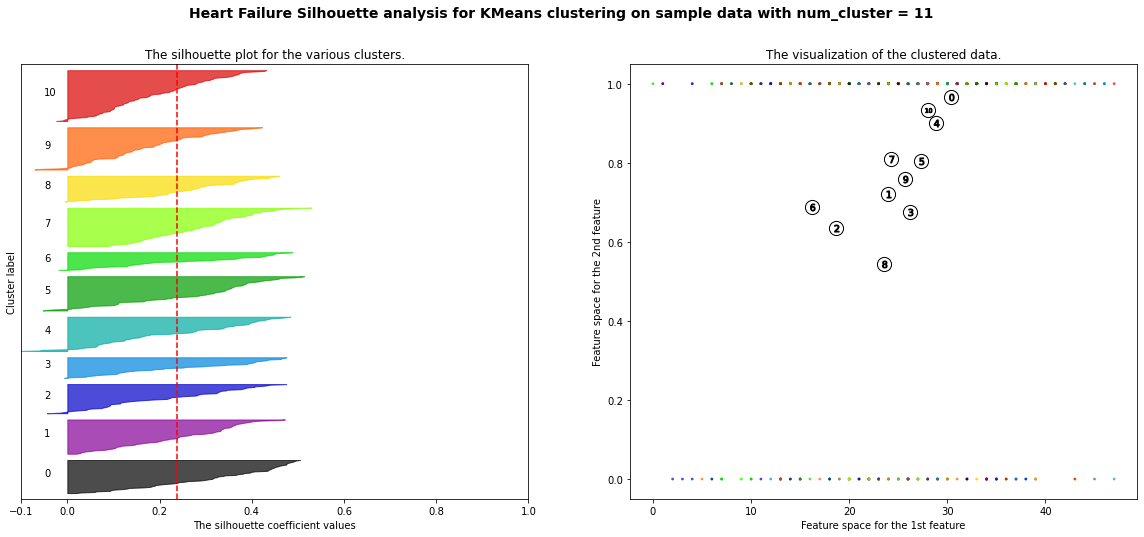

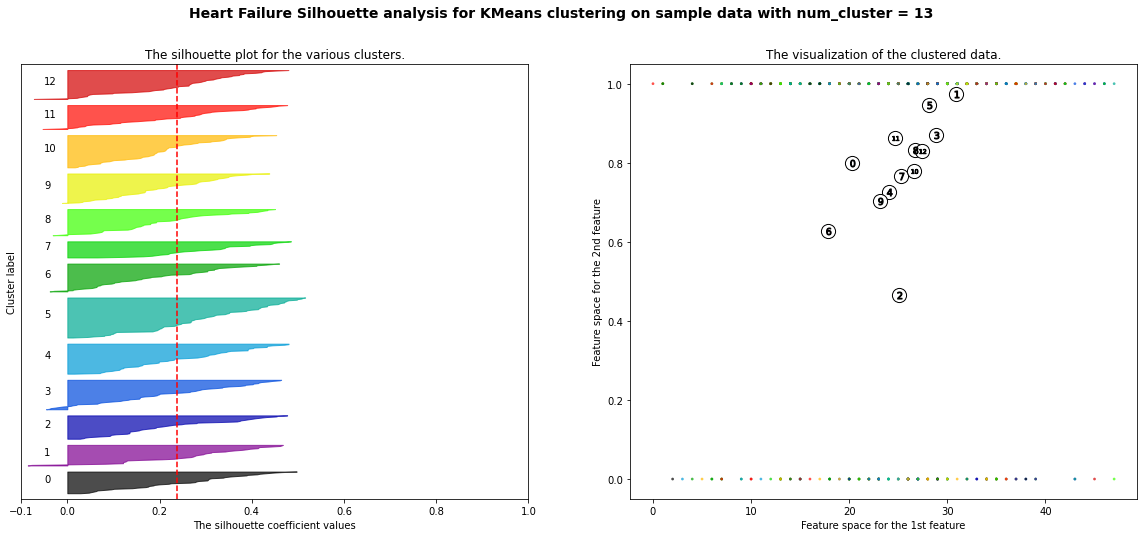

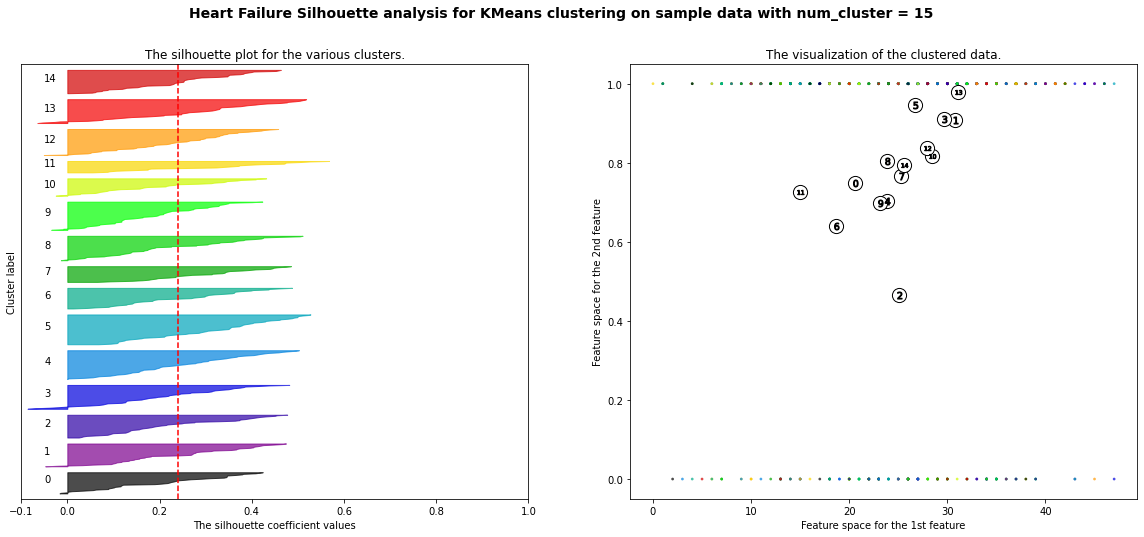

In [71]:
cluster_range = [3, 5,7,9,11,13,15]
for num_cluster in cluster_range:
    figure_to_show, (ax1, ax2) = plt.subplots(1, 2)
    figure_to_show.set_size_inches(20, 8)
   
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_hf_train) + (num_cluster + 1) * 10])
    clusterer = KMeans(n_clusters=num_cluster, random_state=10)
    cluster_labels = clusterer.fit_predict(X_hf_train)
    silhouette_avg = silhouette_score(X_hf_train, cluster_labels)
    print("For n_clusters = ", num_cluster,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X_hf_train, cluster_labels)

    y_lower = 10
    for i in range(num_cluster):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / num_cluster)
    ax2.scatter(X_hf_train.iloc[:, 0], X_hf_train.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Heart Failure Silhouette analysis for KMeans clustering on sample data with num_cluster = %d" % num_cluster),fontsize=14, fontweight='bold')
    plt.savefig('silhouette_hf_%d.png' % num_cluster)

plt.show()

## Stroke

### Results

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=3169)
kmeans.fit(X_s_train)
print('K-Means Inertia: ', kmeans.inertia_)
silh_result = silhouette_score(X_s_train, kmeans.labels_)
print('K-Means Silhouette score: ', silh_result)
AMI = adjusted_mutual_info_score(Y_s_train, kmeans.labels_)
print('K-Means Adjusted Mutual Information (AMI) score: ', AMI)
print()
kmeans.fit_transform(X_s_train)

### Inertia Analysis

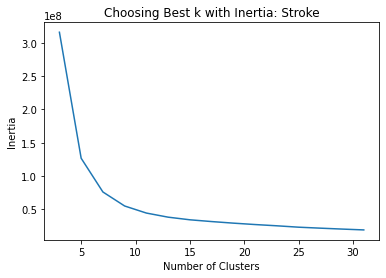

In [72]:
cluster_range = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
inertia_arr = []
for num_cluster in cluster_range:
    clusterer = KMeans(n_clusters=num_cluster, random_state=10)
    cluster_labels = clusterer.fit(X_s_train)
    inertia_arr.append(clusterer.inertia_)
inertia_arr = np.array(inertia_arr)
plt.plot([3,5,7,9,11,13,15,17,19,21,23,25,27,29,31],inertia_arr)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Choosing Best k with Inertia: Stroke')
plt.savefig('inertia_s.png')
plt.show()

### Silhouette Analysis

For n_clusters =  3 The average silhouette_score is : 0.5549551537122922
For n_clusters =  5 The average silhouette_score is : 0.5053378342430372
For n_clusters =  7 The average silhouette_score is : 0.4603168172139675
For n_clusters =  9 The average silhouette_score is : 0.4221625830667821
For n_clusters =  11 The average silhouette_score is : 0.3883269764962383
For n_clusters =  13 The average silhouette_score is : 0.35858912719050795
For n_clusters =  15 The average silhouette_score is : 0.3333169789113984


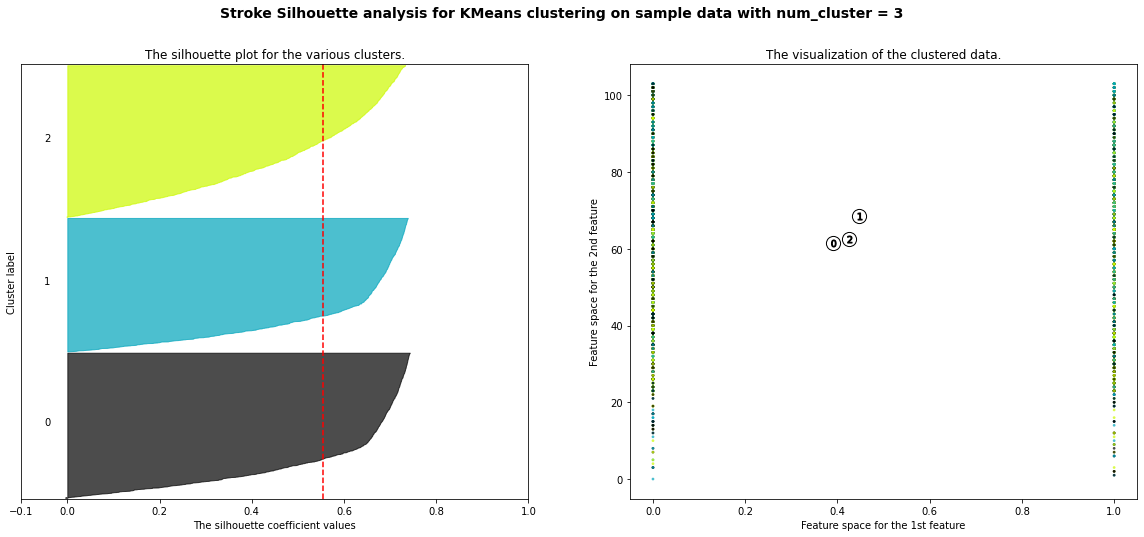

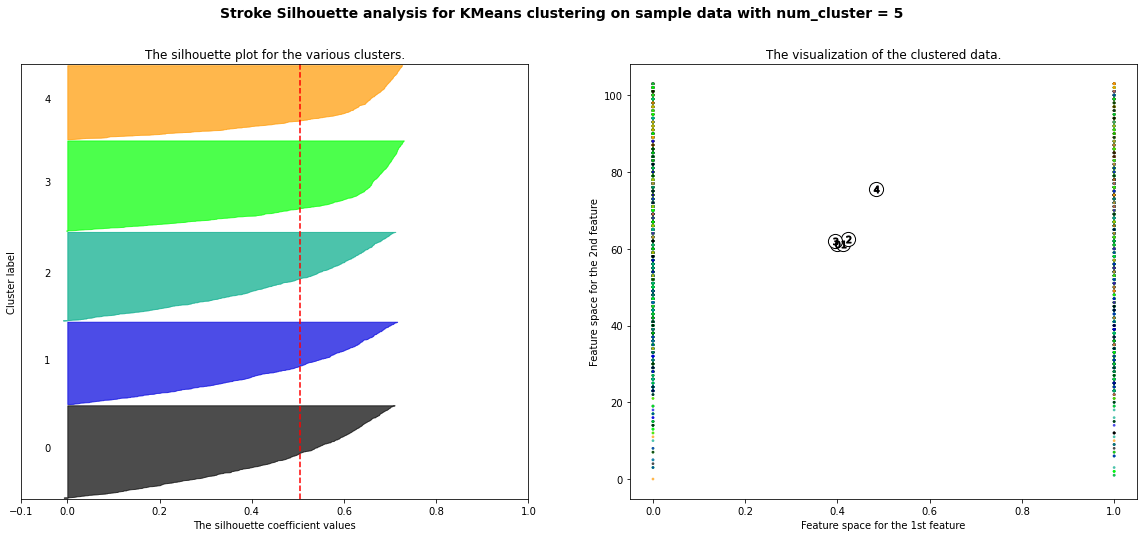

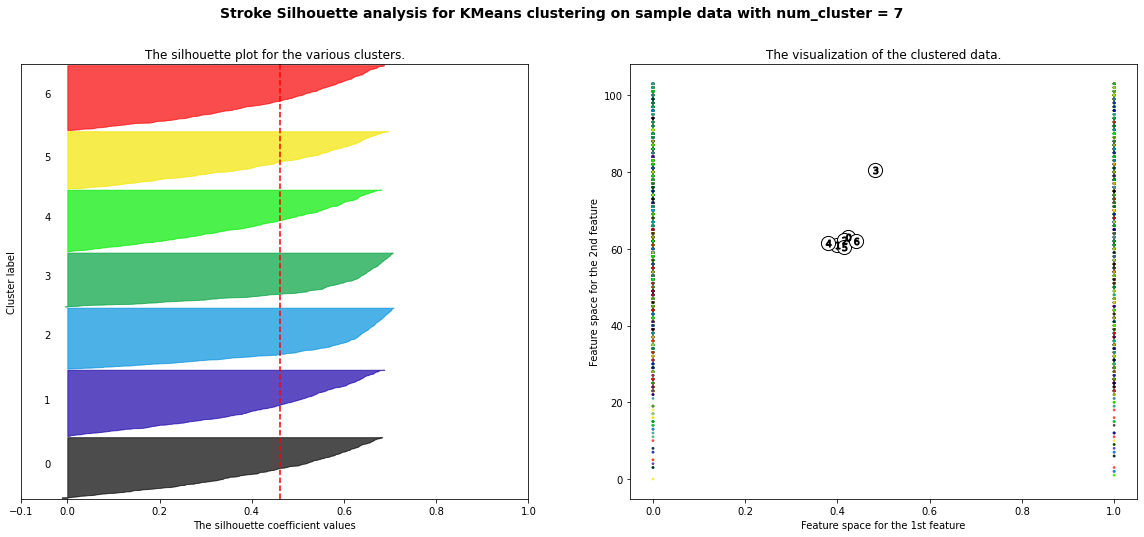

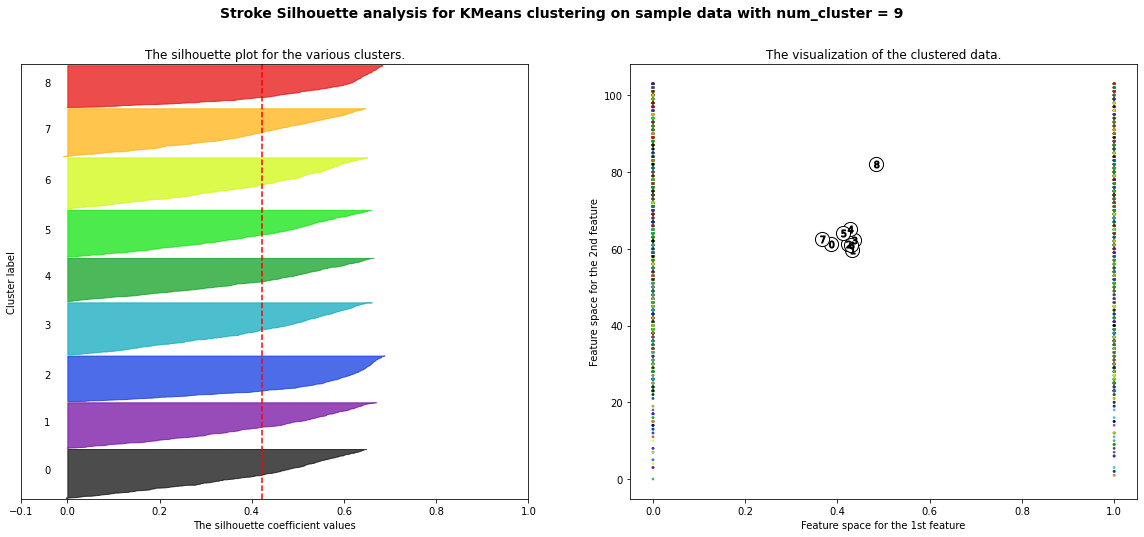

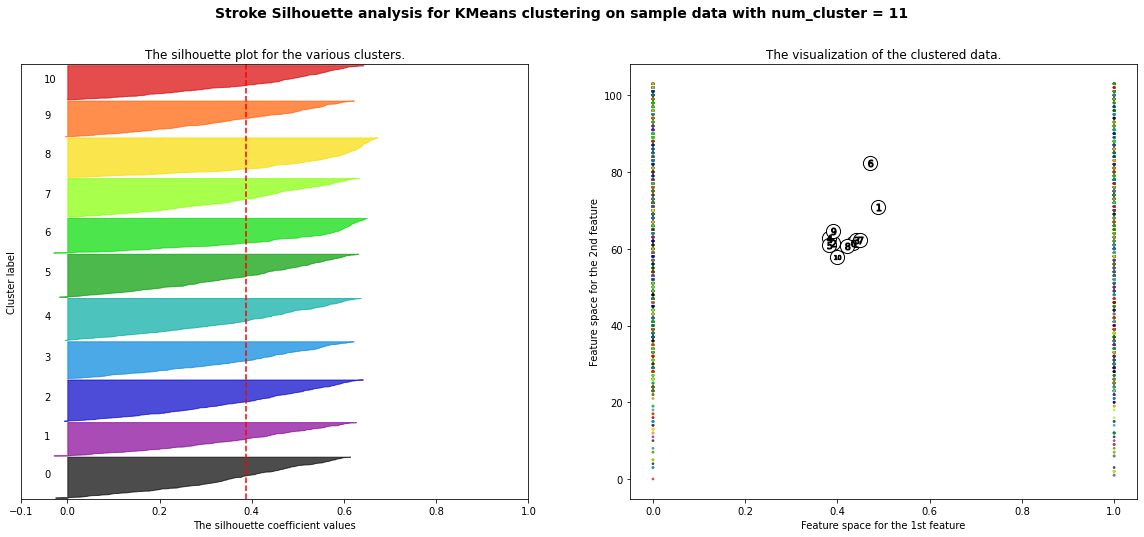

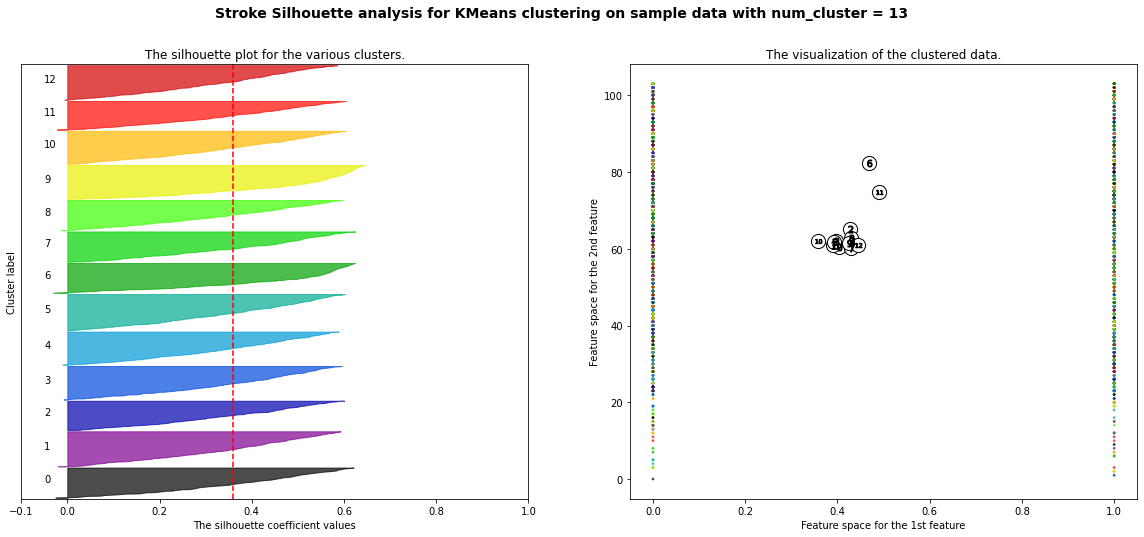

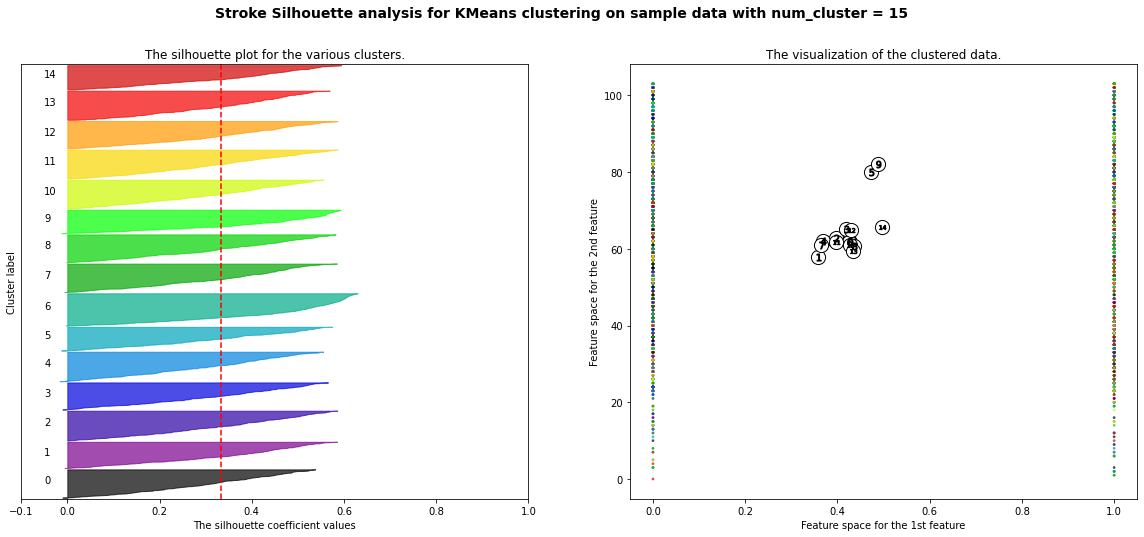

In [73]:
cluster_range = [3, 5,7,9,11,13,15]
for num_cluster in cluster_range:
    figure_to_show, (ax1, ax2) = plt.subplots(1, 2)
    figure_to_show.set_size_inches(20, 8)
   
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_s_train) + (num_cluster + 1) * 10])
    clusterer = KMeans(n_clusters=num_cluster, random_state=10)
    cluster_labels = clusterer.fit_predict(X_s_train)
    silhouette_avg = silhouette_score(X_s_train, cluster_labels)
    print("For n_clusters = ", num_cluster,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X_s_train, cluster_labels)

    y_lower = 10
    for i in range(num_cluster):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / num_cluster)
    ax2.scatter(X_s_train.iloc[:, 0], X_s_train.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Stroke Silhouette analysis for KMeans clustering on sample data with num_cluster = %d" % num_cluster),fontsize=14, fontweight='bold')
    plt.savefig('silhouette_s_%d.png' % num_cluster)
plt.show()


# Gaussian Mixture

## Heart Failure

### Results

In [77]:
gmm_best = GaussianMixture(n_components=2, random_state=3169)
gmm_best.fit(X_hf_train)
gmm_labels = gmm_best.predict(X_hf_train)

print('GMM BIC: ', gmm_best.bic(X_hf_train))
score_gmm = silhouette_score(X_hf_train, gmm_labels)
print('GMM Silhouette score: ', score_gmm)
AMI_gmm = adjusted_mutual_info_score(Y_hf_train, gmm_labels)
print('GMM Adjusted Mutual Information (AMI) score: ', AMI_gmm)
print()
gmm_hf = gmm_best.predict_proba(X_hf_train)
%store gmm_hf

GMM BIC:  19652.91798582151
GMM Silhouette score:  0.03308546088741851
GMM Adjusted Mutual Information (AMI) score:  0.07143893026182722

Stored 'gmm_hf' (ndarray)


### Analysis

21

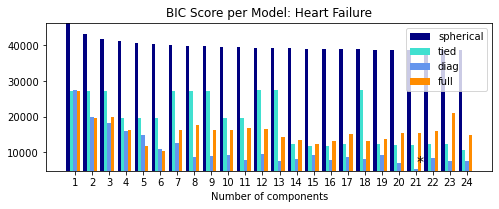

In [58]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 25)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, max_iter=1000)
        gmm.fit(X_hf_train)
        bic.append(gmm.bic(X_hf_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue','darkorange'])
clf = best_gmm
bars = []
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC Score per Model: Heart Failure')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
best_num = np.mod(bic.argmin(), len(n_components_range)) + 1
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.savefig('GMM_hf.png')

best_num

## Stroke

### Results

In [64]:
gmm_best = GaussianMixture(n_components=2, random_state=3169)
gmm_best.fit(X_s_train)
gmm_labels = gmm_best.predict(X_s_train)

print('GMM BIC: ', gmm_best.bic(X_s_train))
score_gmm = silhouette_score(X_s_train, gmm_labels)
print('GMM Silhouette score: ', score_gmm)
AMI_gmm = adjusted_mutual_info_score(Y_s_train, gmm_labels)
print('GMM Adjusted Mutual Information (AMI) score: ', AMI_gmm)
print()
gmm_best.predict_proba(X_s_train)

GMM BIC:  94412.39476016807
GMM Silhouette score:  0.08288129746223813
GMM Adjusted Mutual Information (AMI) score:  0.03039886911455334



array([[9.99999998e-01, 1.81967845e-09],
       [1.00000000e+00, 7.64288853e-21],
       [1.00000000e+00, 8.90887367e-13],
       ...,
       [1.00000000e+00, 2.25132403e-10],
       [9.99999997e-01, 2.78248720e-09],
       [9.99999997e-01, 2.72017481e-09]])

### Analysis

23

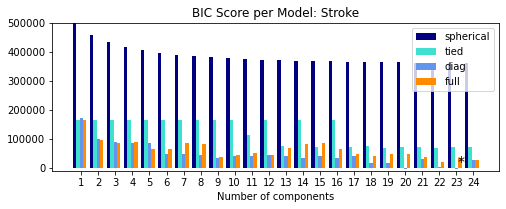

In [65]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 25)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, max_iter=1000)
        gmm.fit(X_s_train)
        bic.append(gmm.bic(X_s_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue','darkorange'])
clf = best_gmm
bars = []
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC Score per Model: Stroke')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
best_num = np.mod(bic.argmin(), len(n_components_range)) + 1
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.savefig('GMM_s.png')

best_num